In [10]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
from scipy.linalg import expm, eig, logm
from qiskit import QuantumCircuit, QuantumRegister, BasicAer, execute
from quantum_circuit.trotterization import trotter_circuit
from operators.triangle_plaquette_hamiltonian import TrianglePlaquetteHamiltonian
import matplotlib.pyplot as plt

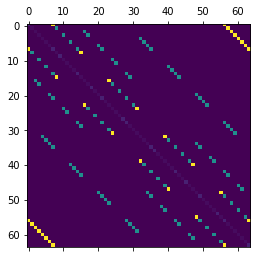

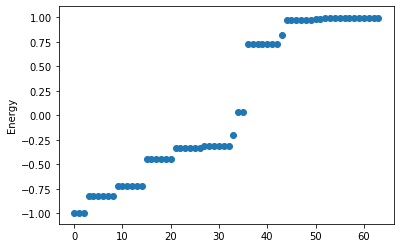

In [23]:
# 2 triangle plaquettes
T = 1
H = TrianglePlaquetteHamiltonian(0.5, 1.0, 2)
exact = expm(-1j*H.matrix_form()*T)
spectrum, _ = eig(exact)
plt.matshow(np.abs(H.matrix_form()))
plt.show()
plt.scatter(range(spectrum.shape[0]), np.sort(spectrum))
plt.ylabel("Energy")
plt.show()

In [6]:
qr = QuantumRegister(6, 'qr')
circ = QuantumCircuit(qr)
circ = trotter_circuit(circ, qr, H, 0.1, 1)
circ.draw()

c:\users\hiroki\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


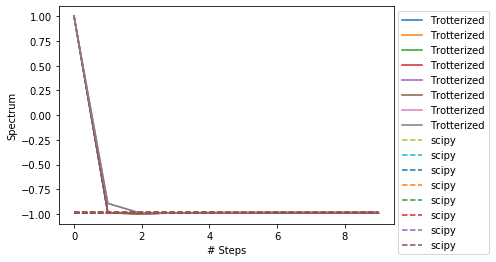

In [4]:
# Initialize Simulator
backend = BasicAer.get_backend('unitary_simulator')

# Construct quantum circuits with different number of steps
tr_spectra = []
for n_steps in range(10):
    # Construct Circuit
    qr = QuantumRegister(6, 'qr')
    circ = QuantumCircuit(qr)
    circ = trotter_circuit(circ, qr, H, T, n_steps)
    job = execute(circ, backend)
    eigvals, _ = eig(job.result().get_unitary(circ, decimals=3))
    tr_spectra.append(sorted(eigvals)[:8])
plt.plot(range(10), tr_spectra, label='Trotterized')
plt.plot(range(10), np.tile(np.reshape(sorted(spectrum)[:8], [1, -1]), [10, 1]), linestyle='--', label='scipy')
plt.xlabel("# Steps")
plt.ylabel("Spectrum")
plt.legend(bbox_to_anchor=(1.3, 1))
plt.show()

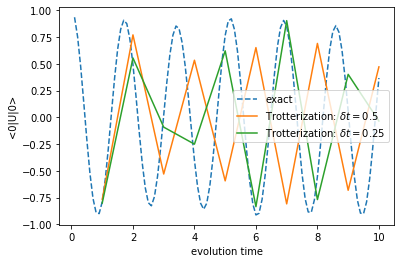

In [10]:
# Initialize Simulator
backend = BasicAer.get_backend('unitary_simulator')
# Compare exact <0|U|0> with trotterized <0|(Uel Ucoup Upla)^n|0> with 5 steps and 20 steps
exact_exps = []
tr_exps5 = []
tr_exps20 = []
for t in np.arange(0.1, 10.1, 0.1):
    zerostate = np.zeros([2**6, 1])
    zerostate[-1, 0] = 1
    exact = expm(-1j*H.matrix_form()*t)
    exact_exps.append(np.dot(np.dot(zerostate.T, expm(-1j*H.matrix_form()*t)), zerostate)[0, 0])
    
for t in np.arange(1, 11):
    # Construct Circuit with n_steps = 20
    qr = QuantumRegister(6, 'qr')
    circ1 = QuantumCircuit(qr)
    circ1 = trotter_circuit(circ1, qr, H, t, 2*t)
    job = execute(circ1, backend)
    tr_unitary1 = job.result().get_unitary(circ1, decimals=3)
    tr_exps5.append(np.dot(np.dot(zerostate.T, tr_unitary1), zerostate)[0, 0])
    # Construct Circuit with n_steps = 60
    qr = QuantumRegister(6, 'qr')
    circ2 = QuantumCircuit(qr)
    circ2 = trotter_circuit(circ2, qr, H, t, 6*t)
    job = execute(circ2, backend)
    tr_unitary2 = job.result().get_unitary(circ2, decimals=3)
    tr_exps20.append(np.dot(np.dot(zerostate.T, tr_unitary2), zerostate)[0, 0])
    
plt.plot(np.arange(0.1, 10.1, 0.1), exact_exps, label='exact', linestyle='--')
plt.plot(range(1, 11), tr_exps5, label='Trotterization: $\delta t=0.5$')
plt.plot(range(1, 11), tr_exps20, label='Trotterization: $\delta t=0.25$')
plt.legend()
plt.xlabel('evolution time')
plt.ylabel('<0|U|0>')
plt.show()

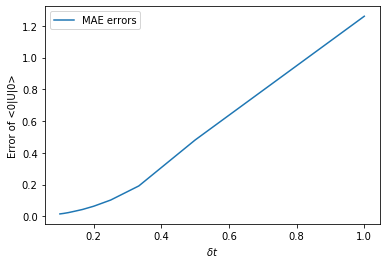

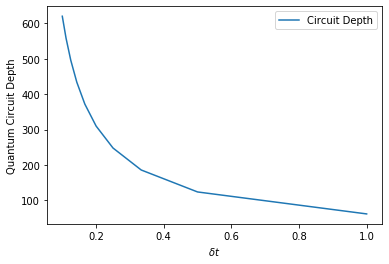

In [7]:
# Initialize Simulator
backend = BasicAer.get_backend('unitary_simulator')
# Compare exact <0|U|0> with trotterized <0|(Uel Ucoup Upla)^n|0> with 5 steps and 20 steps
exact_exps = []

for t in np.arange(1, 2):
    zerostate = np.zeros([2**6, 1])
    zerostate[-1, 0] = 1
    exact = expm(-1j*H.matrix_form()*t)
    exact_exps.append(np.dot(np.dot(zerostate.T, expm(-1j*H.matrix_form()*t)), zerostate)[0, 0])
exact_exps = np.array(exact_exps)
    
error_list = [] # list of errors for delta t = 1/1, 1/2, ..., 1/10
depth_list = []
for n_steps in range(1, 11):
    tr_exps = [] # list of expectation values
    for t in np.arange(1, 2):
        # Construct Circuit
        qr = QuantumRegister(6, 'qr')
        circ = QuantumCircuit(qr)
        circ = trotter_circuit(circ, qr, H, t, n_steps*t)
        job = execute(circ, backend)
        tr_unitary = job.result().get_unitary(circ, decimals=3)
        tr_exps.append(np.dot(np.dot(zerostate.T, tr_unitary), zerostate)[0, 0])
    error_list.append(np.mean(np.abs(np.array(tr_exps) - exact_exps)))
    depth_list.append(circ.depth())
    
plt.plot(1/np.arange(1, 11), error_list, label='MAE errors')
plt.legend()
plt.xlabel('$\delta t$')
plt.ylabel('Error of <0|U|0>')
plt.show()
plt.plot(1/np.arange(1, 11), depth_list, label='Circuit Depth')
plt.legend()
plt.xlabel('$\delta t$')
plt.ylabel('Quantum Circuit Depth')
plt.show()